### Implementacion realizada para el Trabajo de fin de Master en Inteligencia Artificial para la  Universidad Internacional de la Rioja (UNIR).

Realizado por: Fernando Chica Ortiz

**Trabajo de fin de master Uso de técnicas basadas en meta learning para la identificación del locutor.**


Extraccion de Espectrograma de Mel, Downsamplig y Entrenamiento del modelo

La implementación realizada esta basada en la estructura propuesta por Gregory et. al.
en : http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf

También se utilizo la clase Siamese_Loader propuesta por Akshay Sharma que esta disponible en: https://github.com/akshaysharma096/Siamese-Networks bajo licencia **MIT** 


In [0]:
# Importamos las librerias necesarias


from keras.models import Sequential
import time
from keras.optimizers import Adam,SGD
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.engine.topology import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import librosa
import librosa.display

import matplotlib.pyplot as plt
import numpy.random as rng
from sklearn.utils import shuffle
from scipy.io import wavfile
import scipy.signal as sps

import pickle
from skimage.io import imread

# Para el entrenamiento se utiliza la GPU del computador para ello se configura 
# keras 

import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)




Using TensorFlow backend.


In [0]:
# Comprobamos procesadores o GPU disponibles para trabajar

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7695213325105269694
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8245142090148151019
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11613083857241128214
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5413404672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5080168816080993213
physical_device_desc: "device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

W0827 21:49:54.032147 140032752863040 deprecation_wrapper.py:119] From /home/fernando/anaconda3/envs/virSpeech/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0827 21:49:54.034119 140032752863040 deprecation_wrapper.py:119] From /home/fernando/anaconda3/envs/virSpeech/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

## Adecuación del directorio de archivos de la base de datos de voxceleb1

In [0]:
# Funcion que permite re estructurar los datos de la base de datos de voxceleb
# de tal forma que en X se guarda el directorio completo del audio, en y se guarda
# el nombre del locutor y en il se guarda numero del locutor

# Re estructurar los datos
#original

def loadimgs(path,n = 0):
    '''
    path => directorio de archivos
    '''
    X=[]
    y = []
    i1=[]

    i=0
    
    # 
    for locutor in os.listdir(path):
      #y.append(i)
      #print(y)
      print("loading alphabet: " + locutor)
      locutor_path = os.path.join(path,locutor)
      i = 0
        # every letter/category has it's own column in the array, so  load seperately
      for letter in os.listdir(locutor_path):
          letter_path = os.path.join(locutor_path, letter)
                        
            # read all the images in the current category
          for filename in os.listdir(letter_path):
              image_path = os.path.join(letter_path, filename)
              
              f, wav = wavfile.read(image_path)
              
              if len(wav) >= 80000:
                
                X.append(image_path)
                i=i+1

          
      y.append(locutor)
      i1.append(i)


                
    return X,y,i1



In [0]:
#  corremos la funcion

Xt,yt,i1t=loadimgs('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/')

yt,i1t

#len(wav), np.shape(wav)

loading alphabet: id10352
loading alphabet: id10890
loading alphabet: id10489
loading alphabet: id10976
loading alphabet: id10755
loading alphabet: id11239
loading alphabet: id10982
loading alphabet: id10687
loading alphabet: id11137
loading alphabet: id10038
loading alphabet: id11025
loading alphabet: id10599
loading alphabet: id11210
loading alphabet: id10216
loading alphabet: id10792
loading alphabet: id10204
loading alphabet: id11228
loading alphabet: id10371
loading alphabet: id10552
loading alphabet: id11065
loading alphabet: id10933
loading alphabet: id10382
loading alphabet: id10014
loading alphabet: id10375
loading alphabet: id10344
loading alphabet: id10495
loading alphabet: id10847
loading alphabet: id10076
loading alphabet: id11067
loading alphabet: id10666
loading alphabet: id11111
loading alphabet: id10957
loading alphabet: id10732
loading alphabet: id10797
loading alphabet: id10039
loading alphabet: id10160
loading alphabet: id10267
loading alphabet: id10811
loading alph

loading alphabet: id10711
loading alphabet: id10510
loading alphabet: id11014
loading alphabet: id10706
loading alphabet: id10418
loading alphabet: id11096
loading alphabet: id10180
loading alphabet: id10917
loading alphabet: id10906
loading alphabet: id10156
loading alphabet: id11157
loading alphabet: id10973
loading alphabet: id11079
loading alphabet: id11190
loading alphabet: id10708
loading alphabet: id11030
loading alphabet: id10141
loading alphabet: id10771
loading alphabet: id11140
loading alphabet: id10509
loading alphabet: id10840
loading alphabet: id10253
loading alphabet: id10177
loading alphabet: id10704
loading alphabet: id11209
loading alphabet: id10113
loading alphabet: id10571
loading alphabet: id10442
loading alphabet: id10317
loading alphabet: id10224
loading alphabet: id10068
loading alphabet: id11105
loading alphabet: id10813
loading alphabet: id11045
loading alphabet: id11136
loading alphabet: id10356
loading alphabet: id11043
loading alphabet: id11041
loading alph

loading alphabet: id11153
loading alphabet: id10390
loading alphabet: id10869
loading alphabet: id10652
loading alphabet: id10682
loading alphabet: id11165
loading alphabet: id10012
loading alphabet: id10646
loading alphabet: id10562
loading alphabet: id10738
loading alphabet: id10611
loading alphabet: id10983
loading alphabet: id10806
loading alphabet: id11009
loading alphabet: id10469
loading alphabet: id10422
loading alphabet: id10765
loading alphabet: id10701
loading alphabet: id10189
loading alphabet: id10016
loading alphabet: id10044
loading alphabet: id10695
loading alphabet: id10915
loading alphabet: id10487
loading alphabet: id10448
loading alphabet: id10466
loading alphabet: id11235
loading alphabet: id10566
loading alphabet: id10050
loading alphabet: id10883
loading alphabet: id10781
loading alphabet: id11217
loading alphabet: id10367
loading alphabet: id10179
loading alphabet: id10607
loading alphabet: id10520
loading alphabet: id11245
loading alphabet: id10634
loading alph

loading alphabet: id11095
loading alphabet: id10439
loading alphabet: id11246
loading alphabet: id11249
loading alphabet: id10838
loading alphabet: id10505
loading alphabet: id10252
loading alphabet: id10762
loading alphabet: id10987
loading alphabet: id10959
loading alphabet: id10942
loading alphabet: id10214
loading alphabet: id10268
loading alphabet: id10809
loading alphabet: id10235
loading alphabet: id10963
loading alphabet: id10148
loading alphabet: id10460
loading alphabet: id10918
loading alphabet: id10910
loading alphabet: id11167
loading alphabet: id10343
loading alphabet: id10357
loading alphabet: id10311
loading alphabet: id11168
loading alphabet: id10842
loading alphabet: id10496
loading alphabet: id10139
loading alphabet: id10378
loading alphabet: id10427
loading alphabet: id11031
loading alphabet: id10667
loading alphabet: id11007
loading alphabet: id10155
loading alphabet: id11124
loading alphabet: id10524
loading alphabet: id10804
loading alphabet: id10631
loading alph

(['id10352',
  'id10890',
  'id10489',
  'id10976',
  'id10755',
  'id11239',
  'id10982',
  'id10687',
  'id11137',
  'id10038',
  'id11025',
  'id10599',
  'id11210',
  'id10216',
  'id10792',
  'id10204',
  'id11228',
  'id10371',
  'id10552',
  'id11065',
  'id10933',
  'id10382',
  'id10014',
  'id10375',
  'id10344',
  'id10495',
  'id10847',
  'id10076',
  'id11067',
  'id10666',
  'id11111',
  'id10957',
  'id10732',
  'id10797',
  'id10039',
  'id10160',
  'id10267',
  'id10811',
  'id10102',
  'id10166',
  'id10540',
  'id10123',
  'id10934',
  'id10719',
  'id10137',
  'id10756',
  'id11011',
  'id10049',
  'id10586',
  'id10154',
  'id10819',
  'id10430',
  'id10478',
  'id10956',
  'id10615',
  'id10197',
  'id11091',
  'id10507',
  'id10683',
  'id11127',
  'id10650',
  'id10545',
  'id10734',
  'id10931',
  'id10467',
  'id11072',
  'id11035',
  'id10082',
  'id10322',
  'id10735',
  'id10071',
  'id10876',
  'id11170',
  'id11200',
  'id10435',
  'id10192',
  'id10948',

In [0]:
# comprobamos lo obtenido en la variable Xt que son los directorios de los archivos de audio
Xt

['/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/BnDMODRaGfU/00004.wav',
 '/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/BnDMODRaGfU/00002.wav',
 '/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/BnDMODRaGfU/00005.wav',
 '/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/BnDMODRaGfU/00003.wav',
 '/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/PTAn7JS-Vng/00001.wav',
 '/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/PTAn7JS-Vng/00004.wav',
 '/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/PTAn7JS-Vng/00002.wav',
 '/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/PTAn7JS-Vng/00005.wav',
 '/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/C-2Zh9YOZmY/00006.wav',
 '/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/C-2Zh9YOZmY/00004.wav',
 '/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_train/id10352/C-2Zh9YOZmY/00008.wav',
 '/home/fernando/Arch

In [0]:
# Con la informacion de los nombres de los locutores, se procede a crear un nuevo
# directorio que contiene por cada locutor se tiene una sola carpeta con una cantidad 
# de observaciones determinadas por ob donde cada observacion corresponde a un audio 
# de tamaño de 5 segundos (fs=16000*5seg = 80000)



fol=0
ob=20   # Cantidad de observaciones por carpeta
path='/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/prueba/train/'


for loc in yt:
    matching = [s for s in Xt if loc in s]
    filename = path+loc+'/'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    for ob1 in range(ob):
        f, wav = wavfile.read(matching[ob1+fol])
     
        wavfile.write(filename+str(ob1+fol),f,wav[0:80000])
    

## Creacion del modelo de la red neuronal siamesa

In [0]:
# En el articulo propuesto por Gregory et. al. se sugiere inicializar la CNN
# utilizando una media de 0 y std de 0.01 para los pesos sinapticos
# y utilizando una media de 0.5 y std de 0.01 para el bias

def initialize_weights(shape, name=None):

    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)


def initialize_bias(shape, name=None):

    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)



In [0]:
# Función que crea el modelo para la red neuronal siamesa


def get_siamese_model(input_shape):
  

    # Se definen los tensores para la observacion de referencia  (anchor)
    # y para la observacion a definir si pernece o no a un locutor particular
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (4,4), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D())
    model.add(Conv2D(128, (2,2), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())

    model.add(MaxPooling2D())
    model.add(Conv2D(256, (2,2), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

### Se definen funciones que permiten leer los archivos de audio y procesarlas según el enfoque: i-vectores, espectrograma de mel o downsampling

In [0]:
# Para leer los archivos de i-vectores

def loadivec(path,n = 0):

    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n

    for locutor in os.listdir(path):
        print("cargando locutor: " + locutor)
        lang_dict[locutor] = [curr_y,None]
        locutor_path = os.path.join(path,locutor)

        category_ivect=[]

        for filename in os.listdir(locutor_path):
            ivect_path = os.path.join(locutor_path, filename)
            ivect = imread(ivect_path)
            category_ivect.append(ivect)
            y.append(curr_y)
        try:
            X.append(np.stack(category_ivect))

        except ValueError as e:
            print(e)
            print("error - category_images:", category_ivect)
        curr_y += 1
        lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [0]:
#Para leer archivos de auido y remuestrear su frecuencia de muestreo (downsampling)

def loadwavs(path,new_rate,downsampling=False,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n

    for locutor in os.listdir(path):
        print("cargando locutor: " + locutor)
        lang_dict[locutor] = [curr_y,None]
        locutor_path = os.path.join(path,locutor)
        category_down=[]

        for filename in os.listdir(locutor_path):
                      
            wav_path = os.path.join(locutor_path, filename)
            f, wav = wavfile.read(wav_path)
            
            #downsampling 
            if downsampling:
                number_of_samples = round(len(wav) * float(new_rate) / f)
                image = sps.resample(wav, number_of_samples)
            
            sh = int(np.floor(np.sqrt(len(wav))))
            sh2 = sh*sh
            
            wav = np.reshape(wav[0:sh2],[sh,sh])
            
            category_down.append(wav)
            y.append(curr_y)
        try:
            X.append(np.stack(category_wav))
            
        except ValueError as e:
            print(e)
            print("error - category_images:", category_down)
        curr_y += 1
        lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [0]:
# transforma wav en imagen mel
# otro enfoque

def loadwavs_mel(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n

    for locutor in os.listdir(path):
        print("cargando locutor: " + locutor)
        lang_dict[locutor] = [curr_y,None]
        locutor_path = os.path.join(path,locutor)
        category_mel=[]

        for filename in os.listdir(locutor_path):
            
            wav_path = os.path.join(locutor_path, filename)
            
            #espectrograma de mel
            
            data = librosa.core.load(wav_path, sr=16000)[0]
            S1 = librosa.feature.melspectrogram(data,sr=16000,n_mels=67,hop_length=1200)
            S2 = mel_db = librosa.power_to_db(S1, ref=np.max)
            
            category_mel.append(S2)
            y.append(curr_y)
        try:
            X.append(np.stack(category_mel))
        except ValueError as e:
            print(e)
            print("error - category_images:", category_mel)
        curr_y += 1
        lang_dict[alphabet][1] = curr_y - 1
        
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

In [0]:
# prueba realizada para obtener el espectrograma de mel y visualizarlo

data = librosa.core.load('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/prueba/train/id10352/17', sr=16000)[0]
            
S1 = librosa.feature.melspectrogram(data,sr=16000,n_mels=67,hop_length=1200)

S2 = mel_db = librosa.power_to_db(S1, ref=np.max)

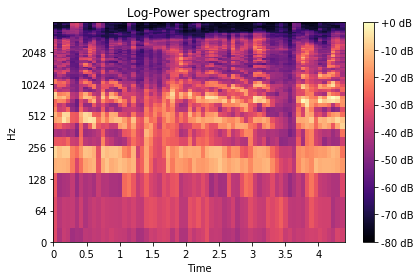

In [0]:
librosa.display.specshow(S2, y_axis='log', x_axis='time',sr=7800)
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Power spectrogram')
plt.tight_layout()
plt.show()

### Se cargan los archivos según el enfoque a utilizar

In [0]:
# Para los datos de entrenamientos

#downsampling

#X,y,c=loadwavs('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/prueba/train/',1000,True)

#ivect

#X,y,c=loadimgs('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_test_tfm/ivect_image_train_900')

# mel
X,y,c=loadwavs_mel('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/prueba/train/')


In [0]:
X.shape

(684, 25, 70, 70)

In [0]:
# Se guarda la variable que contiene los audios preprocesados

# down mel
with open(os.path.join('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_test_tfm/',"train_mel_all1.pickle"), "wb") as f:
    pickle.dump((X,c),f)
    

    

In [0]:
# Para los datos de testeo

#downsampling
#Xval,yval,cval=loadwavs('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/prueba/test/',1000,True)

#mel
Xval,yval,cval=loadwavs_mel('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/prueba/test/')

#ivect
#Xval,yval,cval=loadimgs('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_test_tfm/ivect_image_test_900')


loading alphabet: id10294
loading alphabet: id10308
loading alphabet: id10284
loading alphabet: id10291
loading alphabet: id10293
loading alphabet: id10286
loading alphabet: id10299
loading alphabet: id10272
loading alphabet: id10279
loading alphabet: id10287
loading alphabet: id10292
loading alphabet: id10285
loading alphabet: id10295
loading alphabet: id10300
loading alphabet: id10280
loading alphabet: id10283
loading alphabet: id10277
loading alphabet: id10304
loading alphabet: id10288
loading alphabet: id10281
loading alphabet: id10271
loading alphabet: id10270
loading alphabet: id10274
loading alphabet: id10297
loading alphabet: id10296
loading alphabet: id10290
loading alphabet: id10306
loading alphabet: id10273
loading alphabet: id10307
loading alphabet: id10289
loading alphabet: id10302
loading alphabet: id10309
loading alphabet: id10276
loading alphabet: id10282
loading alphabet: id10278
loading alphabet: id10275
loading alphabet: id10303
loading alphabet: id10305
loading alph

In [0]:
Xval.shape

(40, 25, 70, 70)

In [0]:
# Se guarda variable que contiene audios de testeo


with open(os.path.join('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_test_tfm/wav_test',"val_mel_all1.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)
    
#with open(os.path.join('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_test_tfm/ivect_image_test_900',"val.pickle"), "wb") as f:
#    pickle.dump((Xval,cval),f)    


### Cargamos las variables que contienen los audios procesados

In [0]:
# Datos de entrenamiento

#mel down
with open(os.path.join('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_test_tfm/',"train_mel_all1.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)
    
# ivect    
#with open(os.path.join('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_test_tfm/ivect_image_train_900',"train.pickle"), "rb") as f:
#    (Xtrain, train_classes) = pickle.load(f)
    
print(list(train_classes.keys()))

['id10352', 'id10890', 'id10489', 'id10976', 'id10755', 'id11239', 'id10982', 'id10687', 'id11137', 'id10038', 'id11025', 'id10599', 'id11210', 'id10216', 'id10792', 'id10204', 'id11228', 'id10371', 'id10552', 'id11065', 'id10933', 'id10382', 'id10014', 'id10375', 'id10344', 'id10495', 'id10847', 'id10076', 'id11067', 'id10666', 'id11111', 'id10957', 'id10732', 'id10797', 'id10039', 'id10160', 'id10267', 'id10811', 'id10102', 'id10166', 'id10540', 'id10123', 'id10934', 'id10719', 'id10137', 'id10756', 'id11011', 'id10049', 'id10586', 'id10154', 'id10819', 'id10430', 'id10478', 'id10956', 'id10615', 'id10197', 'id11091', 'id10507', 'id10683', 'id11127', 'id10650', 'id10545', 'id10734', 'id10931', 'id10467', 'id11072', 'id11035', 'id10082', 'id10322', 'id10735', 'id10071', 'id10876', 'id11170', 'id11200', 'id10435', 'id10192', 'id10948', 'id10493', 'id10547', 'id10601', 'id10088', 'id10712', 'id10426', 'id10321', 'id10327', 'id11037', 'id11203', 'id10617', 'id10436', 'id10223', 'id10568'

In [0]:
# Datos de testeo

# mel down
with open(os.path.join('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_test_tfm/wav_test',"val_mel_all1.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

# ivect

#with open(os.path.join('/home/fernando/Archivos/Voxceleb/Vox_Celeb_1/wav_test_tfm/ivect_image_test_900',"val.pickle"), "rb") as f:
#    (Xval, val_classes) = pickle.load(f)
    
    
print(list(val_classes.keys()))

['id10294', 'id10308', 'id10284', 'id10291', 'id10293', 'id10286', 'id10299', 'id10272', 'id10279', 'id10287', 'id10292', 'id10285', 'id10295', 'id10300', 'id10280', 'id10283', 'id10277', 'id10304', 'id10288', 'id10281', 'id10271', 'id10270', 'id10274', 'id10297', 'id10296', 'id10290', 'id10306', 'id10273', 'id10307', 'id10289', 'id10302', 'id10309', 'id10276', 'id10282', 'id10278', 'id10275', 'id10303', 'id10305', 'id10301', 'id10298']


In [0]:
# Basado en la clase Siamese_Loader

def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets


def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)
        
        
        
def make_oneshot_task(N, s="eval", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

    return pairs, targets


def test_oneshot(model, N, k, s = "eval", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [0]:
# Se definen los hiperparametros del modelo

evaluate_every = 242 # Intervalo donde se evalua la exactitud del modelo
batch_size = 100     # tamaño del batch
n_iter = 20000       # cantidad de iteraciones
N_way = 4            # N clases para evaluar one-shot 
n_val = 200          # Cuantas pruebas se realizaron para evaluar la exactitud
best = -1            # variable que guarda el mejor valor de exactitud del entrenamiento

model_path = ''     

In [0]:
# Se define la red neuronal siamesa, el tamaño de la entrada varia dependiendo de 
# el enfoque utilizado para i-vectores puede ser (20,20-30,30-40-40) depende del tamaño del i-vector
# el enfoque de mel tiene un tamaño de (67,67)
# el enfoque de downsampling tiene un tamaño de (70,70)

model = get_siamese_model((67, 67, 1))
model.summary()

W0918 21:49:11.719462 140639398221632 deprecation_wrapper.py:119] From /home/fernando/anaconda3/envs/virSpeech/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0918 21:49:11.722056 140639398221632 deprecation_wrapper.py:119] From /home/fernando/anaconda3/envs/virSpeech/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0918 21:49:11.758084 140639398221632 deprecation_wrapper.py:119] From /home/fernando/anaconda3/envs/virSpeech/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0918 21:49:11.758707 140639398221632 deprecation_wrapper.py:119] From /home/fernando/anaconda3/envs/virSpeech/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 67, 67, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 67, 67, 1)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         26550080    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]               
          

In [0]:
# compilamos el modelo definido

optimizer = Adam(lr = 0.00001,)
model.compile(loss="binary_crossentropy",optimizer=optimizer)



W0918 21:49:15.121325 140639398221632 deprecation_wrapper.py:119] From /home/fernando/anaconda3/envs/virSpeech/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0918 21:49:15.126765 140639398221632 deprecation.py:323] From /home/fernando/anaconda3/envs/virSpeech/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
print("Inicia entrenamiento")
print('Tamaño del batch')
print(str(batch_size))
print("-------------------------------------")

loss1=[]
acc1=[]

for i in range(1, n_iter+1):
    
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    loss1.append(loss)
    
    if i % evaluate_every == 0:

        print("Perdida: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        acc1.append(val_acc)
        if val_acc >= best:
            print("Mejor rendimiento: {0}, anterior: {1}".format(val_acc, best))
            best = val_acc

Inicia entrenamiento
Tamaño del batch
100
-------------------------------------
Perdida: 3.052046537399292
Evaluating model on 200 random 4 way one-shot learning tasks ... 

Got an average of 55.0% 4 way one-shot learning accuracy 

Mejor rendimiento: 55.0, anterior: -1
Perdida: 2.783989906311035
Evaluating model on 200 random 4 way one-shot learning tasks ... 

Got an average of 64.0% 4 way one-shot learning accuracy 

Mejor rendimiento: 64.0, anterior: 55.0


KeyboardInterrupt: 

In [0]:
# Funcion para graficar la tendencia de la perdida y la exactitud con respecto a las iteraciones 

plt.plot(range(len(loss1)),loss1)
plt.ylabel('Loss')
plt.title('Loss one-shot learning')
plt.xlabel('Iteraciones')
plt.savefig('/home/fernando/Desktop/TFM/loss1_me_va'+str(N_way)+'_'+str(batch_size)+'_'+str(np.shape(Xtrain)[3])+'_'+str(int(best)))

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(range(len(acc1)),acc1)
plt.ylabel('Accuracy')
plt.title('Accuracy way one-shot learning')
plt.xlabel('cada 200 iteraciones')
plt.axis([0,len(acc1),0,105])

plt.subplot(122)
plt.scatter(range(len(acc1)),acc1)
plt.ylabel('Accuracy')
plt.title('Accuracy way one-shot learning')
plt.xlabel('cada 200 batches')
plt.axis([0,len(acc1),0,105])
plt.savefig('/home/fernando/Desktop/TFM/acc1_mel_va'+str(N_way)+'_'+str(batch_size)+'_'+str(np.shape(Xtrain)[3])+'_'+str(int(best)))
